# Detecting Cars on the Road

1. Features (color, gradient, and HOG)
2. Classifier (Linear SVM)
3. Slideing window (Multi-scale) 
4. Tracking
5. Pipeline


In [1]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import os
import utils
import importlib as imp
import pipeline_methods
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
import kerasmodel
import pickle
import adv_laneline_detection
# from PIL imopert

C:\Users\modmo\Anaconda2\envs\carnd-term1\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load Test Images

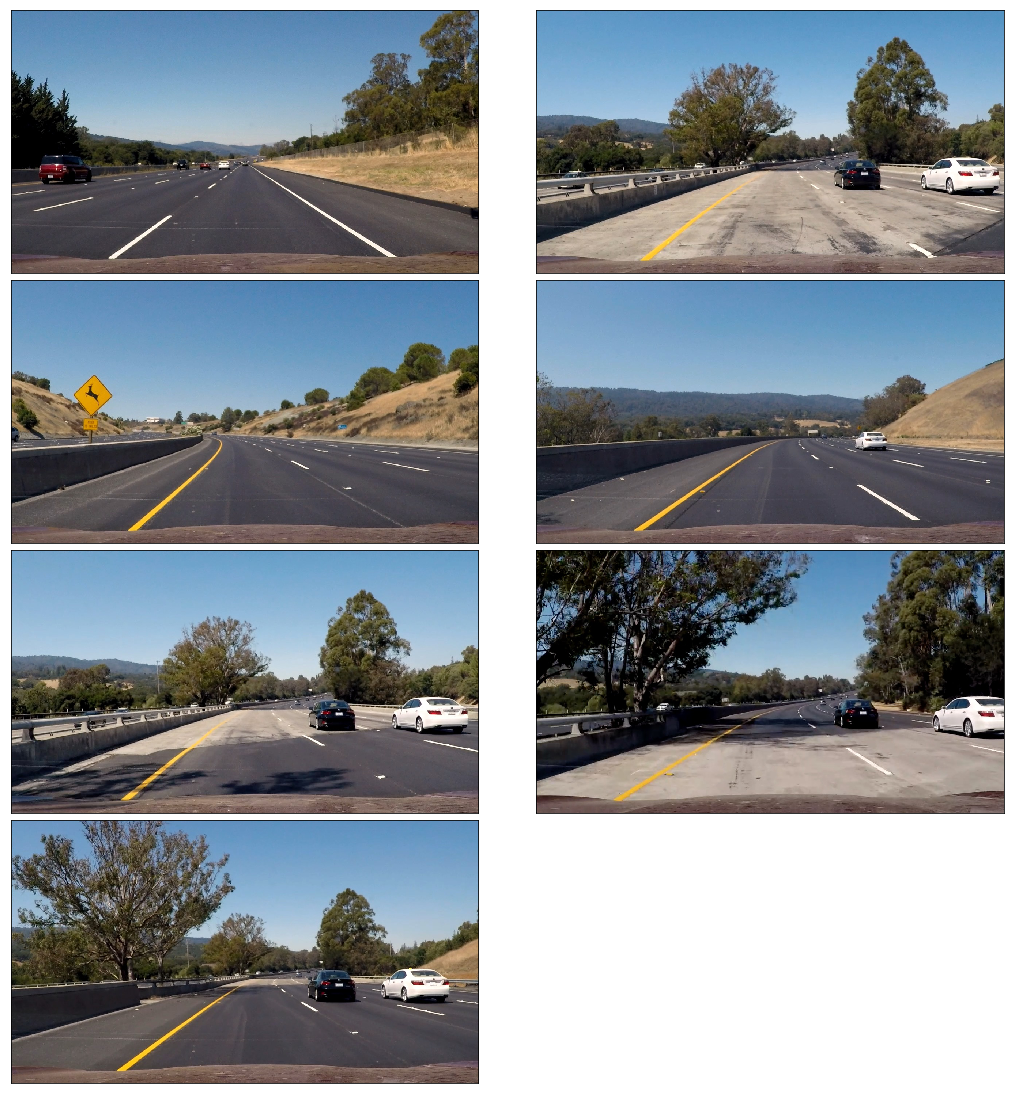

In [2]:
dir = 'test_images/'
project_test_images = [mpimg.imread(dir + image) for image in os.listdir(dir)]
utils.show_images(project_test_images, image_name='test_images', cols=2)

## Load Training Data

We have 8792 vehicle images
We have 8968 non vehicle images


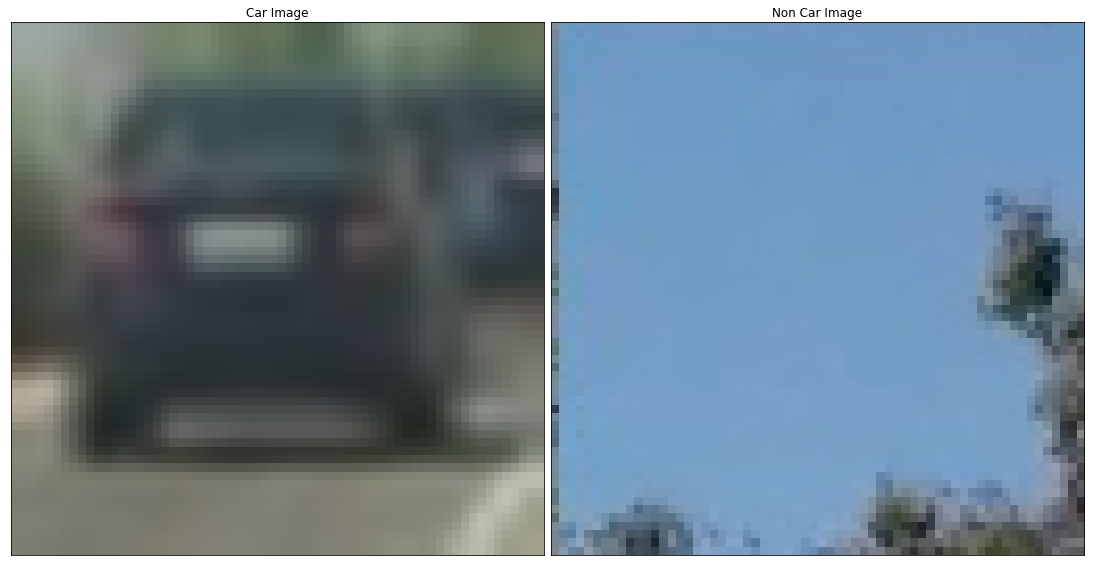

In [3]:
vehicels_dir = './data/vehicles/'
non_vehicels_dir = './data/non-vehicles/'

cars = [] 
for dir_path in os.listdir(vehicels_dir): 
    for image_path in os.listdir(vehicels_dir + dir_path):
        cars.append('{}/{}/{}'.format(vehicels_dir, dir_path ,image_path))
non_cars = [] 
for dir_path in os.listdir(non_vehicels_dir): 
    for image_path in os.listdir(non_vehicels_dir + dir_path):
        non_cars.append('{}/{}/{}'.format(non_vehicels_dir, dir_path ,image_path))

print('We have {} vehicle images'.format(len(cars)))
print('We have {} non vehicle images'.format(len(non_cars)))

utils.show_images([mpimg.imread(cars[0]), mpimg.imread(non_cars[0])],
                  ['Car Image', 'Non Car Image'],
                  image_name='car_non_car',
                  cols=2)

## HOG Features

# 

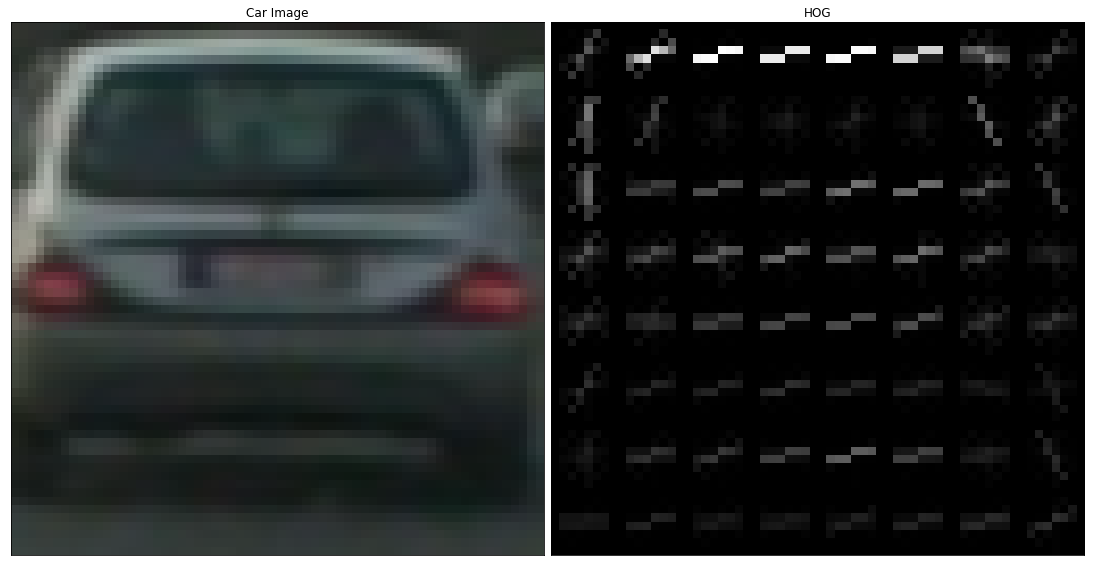

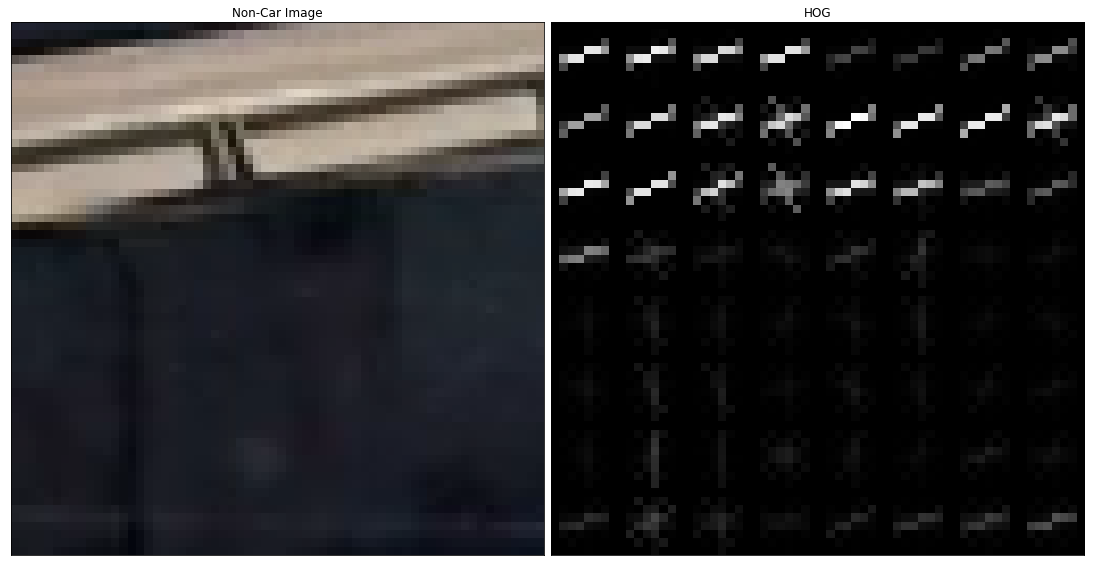

In [4]:
car_image = mpimg.imread(cars[2001])
non_car_image = mpimg.imread(non_cars[3006])
# HOG parameters
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
# Car HOG features

car_hog_features, car_hog_image = pipeline_methods.get_hog_features(car_image[:,:,0], orient, pix_per_cell, cell_per_block, vis=True)
# Non-Car HOG features
non_car_hog_features, non_car_hog_image = pipeline_methods.get_hog_features(non_car_image[:,:,0], orient, pix_per_cell, cell_per_block, vis=True)
# Displaying the images and their HOGs
utils.show_images([car_image, car_hog_image], ['Car Image', 'HOG'], cols=2, image_name='car_hog_image')
utils.show_images([non_car_image, non_car_hog_image], ['Non-Car Image', 'HOG'], cols=2, image_name='non_car_hog_image')

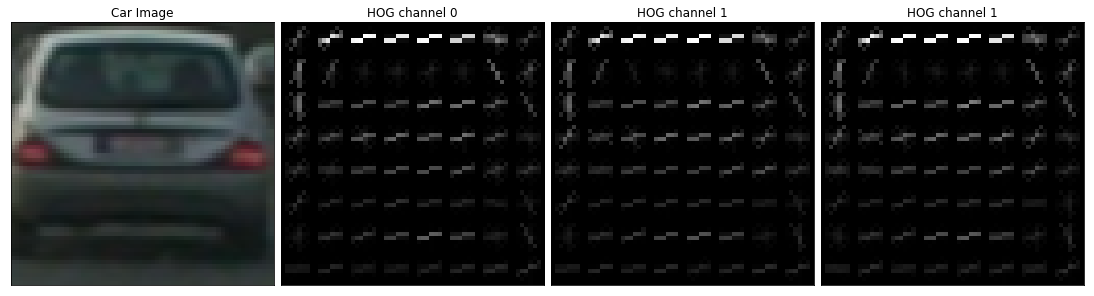

In [5]:
# HOG for all channels
hog_images = []
for channel in range(car_image.shape[2]):
    _, hog_image = pipeline_methods.get_hog_features(car_image[:,:,channel], 
                    orient, pix_per_cell, cell_per_block, 
                    vis=True, feature_vec=True)   
    hog_images.append(hog_image)
utils.show_images([car_image] + hog_images,
                  ['Car Image', 'HOG channel 0', 'HOG channel 1', 'HOG channel 1'],
                  cols=4,
                  image_name='all_car_hog_images')

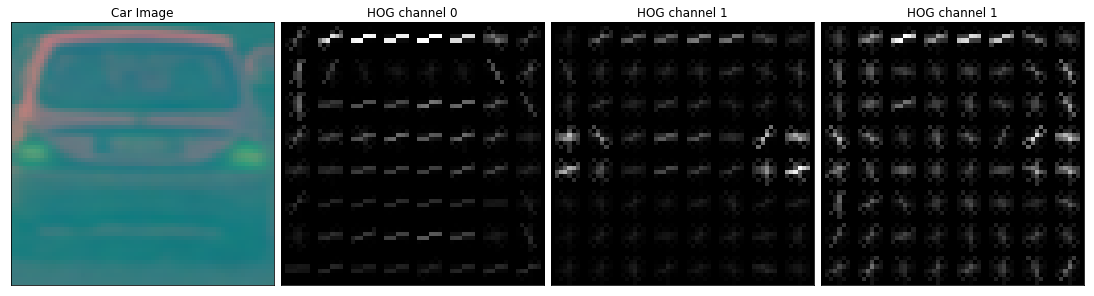

In [6]:
# HOG for all channels for YCrCb
hog_images = []
converted_image = pipeline_methods.convert_color(car_image, conv='RGB2YCrCb')
for channel in range(converted_image.shape[2]):
    _, hog_image = pipeline_methods.get_hog_features(converted_image[:,:,channel], 
                    orient, pix_per_cell, cell_per_block, 
                    vis=True, feature_vec=True)   
    hog_images.append(hog_image)
utils.show_images([converted_image] + hog_images,
                  ['Car Image', 'HOG channel 0', 'HOG channel 1', 'HOG channel 1'],
                  cols=4,
                  image_name='all_car_hog_YCrCb_images')

## Binning (Resizing)

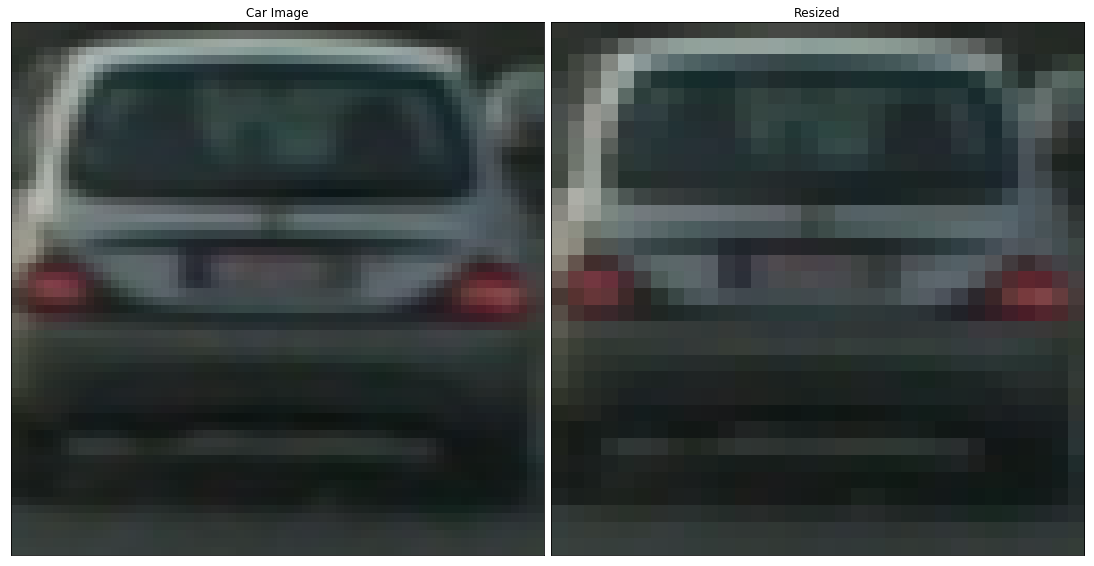

In [7]:
resized = cv2.resize(car_image, (32, 32))
utils.show_images([car_image, resized],
                  ['Car Image', 'Resized'],
                  cols=2,
                  image_name='resized')

## Setup Training

### Combined Features 

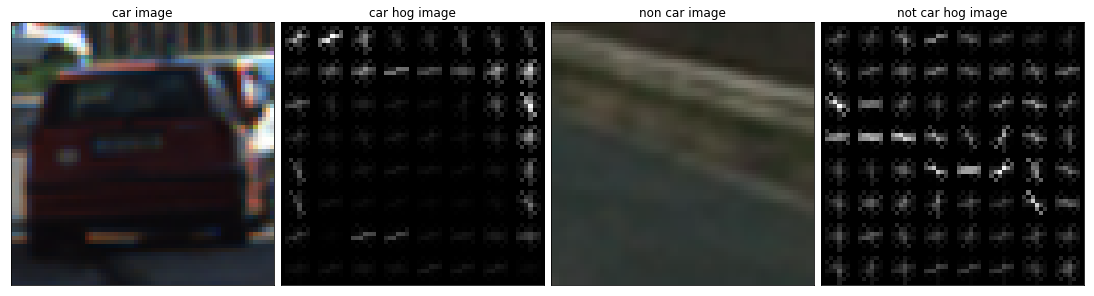

In [8]:
# Feature extraction parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' #Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
# y_start_stop = [460, None] # Min and max in y to search in slide_window()

# Randpm training indices
car_ind = np.random.randint(0, len(cars))

non_car_ind = np.random.randint(0, len(non_cars))

# Read random images
car_image = mpimg.imread(cars[car_ind])
non_car_image = mpimg.imread(non_cars[non_car_ind])

# Feature Extraction for training data
car_features, car_hog_image = pipeline_methods.single_img_features(car_image, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, vis=True,
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features, non_car_hog_image = pipeline_methods.single_img_features(non_car_image, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, vis=True,
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
images_to_show = [car_image, car_hog_image, non_car_image, non_car_hog_image]
titles = ['car image', 'car hog image', 'non car image', 'not car hog image']
utils.show_images(images_to_show, titles, image_name='image_hog')

In [9]:
car_features, car_hog_image = pipeline_methods.single_img_features(car_image, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, vis=True,
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

## Features Extraction

## Training an SVM Classifier

In [10]:
import importlib as imp

In [11]:
imp.reload(pipeline_methods)

<module 'pipeline_methods' from 'C:\\Users\\modmo\\SelfDrivingCar\\projects\\vehicle_detection\\CarND-Vehicle-Detection\\pipeline_methods.py'>

In [12]:
t = time.time()
n_samples = 1000
random_idxs = np.random.randint(0, len(cars), n_samples)
test_cars = cars #np.array(cars)[random_idxs]
test_non_cars = non_cars #np.array(non_cars)[random_idxs]

# print(test_cars[5])
# exit()
print('Started extracting features for ',
      len(test_cars) + len(test_non_cars),
      ' images ...')
car_features = pipeline_methods.extract_features(test_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
non_car_features = pipeline_methods.extract_features(test_non_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print(round(time.time() - t, 3), 'Seconds to extract features for',
      len(test_cars) + len(test_cars),
      'images')

# Stack 
X = np.vstack((car_features, non_car_features)).astype(np.float64)
print('Scaling our extracted features')
# Normalizing the data scale
X_scaler = StandardScaler().fit(X)
# Apply scaler normalization 
scaled_X = X_scaler.transform(X)
# Create labels
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

# Shuffle and Split up the data to a trainig and test sets 
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X,
                                                    y,
                                                    test_size=0.1,
                                                    random_state=rand_state)
# Classifier
svc = LinearSVC()
# Fitting
print('Fitting out classifier our extracted features')
t = time.time()
svc.fit(X_train, y_train)
print(round(time.time() - t, 2), 'Seconds to train')
# Test the classifier
print('Test Accuracy of the Classifier is: ', round(svc.score(X_test, y_test), 4))

Started extracting features for  17760  images ...
117.497 Seconds to extract features for 17584 images
Scaling our extracted features
Fitting out classifier our extracted features
36.06 Seconds to train
Test Accuracy of the Classifier is:  0.9842


## Window Search

0.0 1.0
1.7783968448638916 seconds to process one image searching 273 windows
0.0 1.0
1.7426226139068604 seconds to process one image searching 273 windows
0.0 1.0
1.7068417072296143 seconds to process one image searching 273 windows
0.0 1.0
1.6979167461395264 seconds to process one image searching 273 windows
0.0 1.0
1.7193613052368164 seconds to process one image searching 273 windows
0.0 1.0
1.701667070388794 seconds to process one image searching 273 windows
0.0 1.0
1.7053298950195312 seconds to process one image searching 273 windows


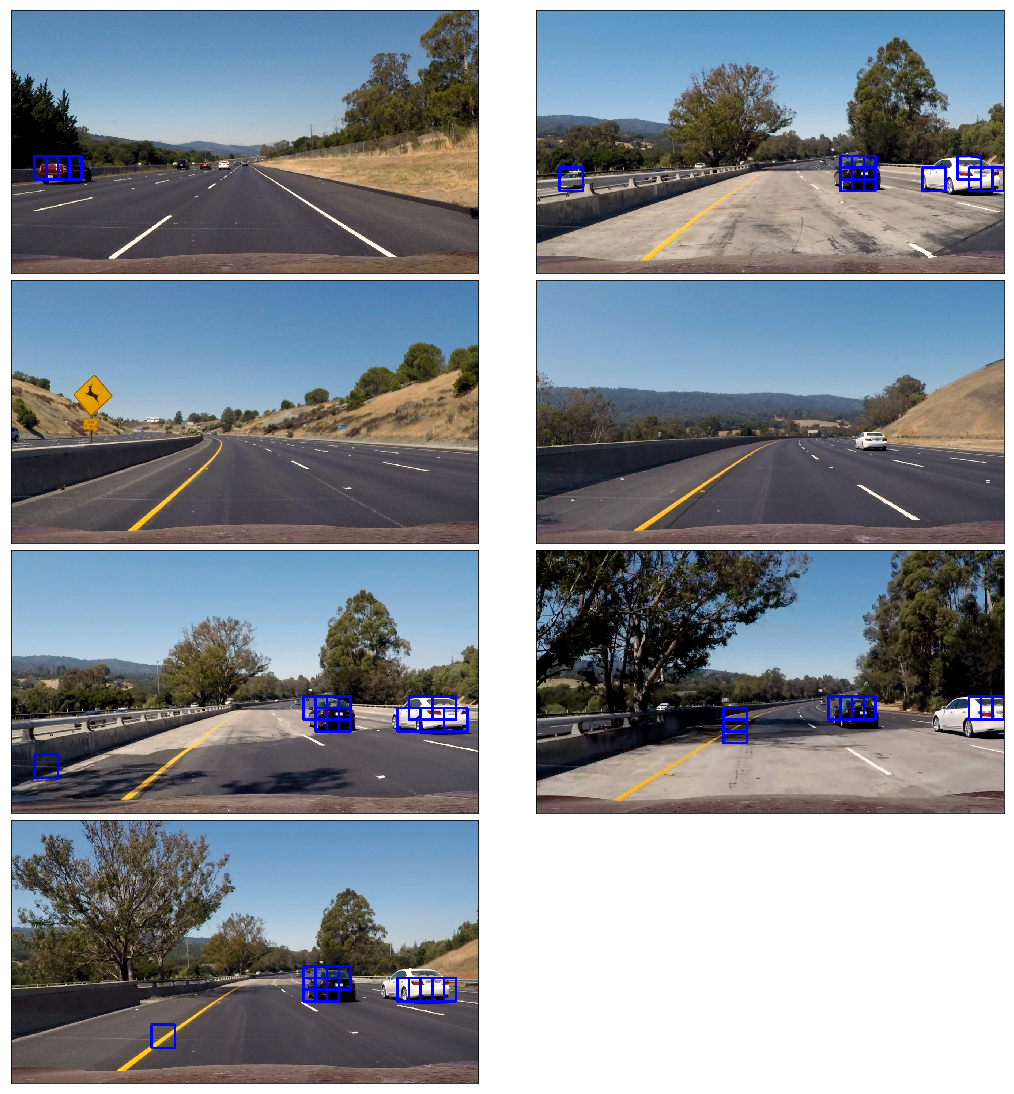

In [13]:
y_start_stop = [400, 656]
overlap = 0.5
images = []
for img in project_test_images:
    t1 = time.time()
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255 # Jpg and png conversion 
    print(np.min(img), np.max(img))
#     plt.imshow(img)
#     plt.show()
    windows = pipeline_methods.slide_window(img, 
                                            x_start_stop=[None, None], 
                                            y_start_stop=y_start_stop,
                                            xy_window=(64, 64),
                                            xy_overlap=(overlap, overlap))
    hot_windows = pipeline_methods.search_windows(img,
                                                  windows,
                                                  svc,
                                                  X_scaler,
                                                  color_space=color_space, 
                                                  spatial_size=spatial_size, 
                                                  hist_bins=hist_bins, 
                                                  orient=orient,
                                                  pix_per_cell=pix_per_cell,
                                                  cell_per_block=cell_per_block, 
                                                  hog_channel=hog_channel,
                                                  spatial_feat=spatial_feat, 
                                                  hist_feat=hist_feat, hog_feat=hog_feat)
    
    # Draw the boxes
    window_image = pipeline_methods.draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)
    images.append(window_image)
    print(time.time() - t1, 'seconds to process one image searching', len(windows), 'windows')
utils.show_images(images, image_name='predicted image', cols=2)    
    

## Heat Map

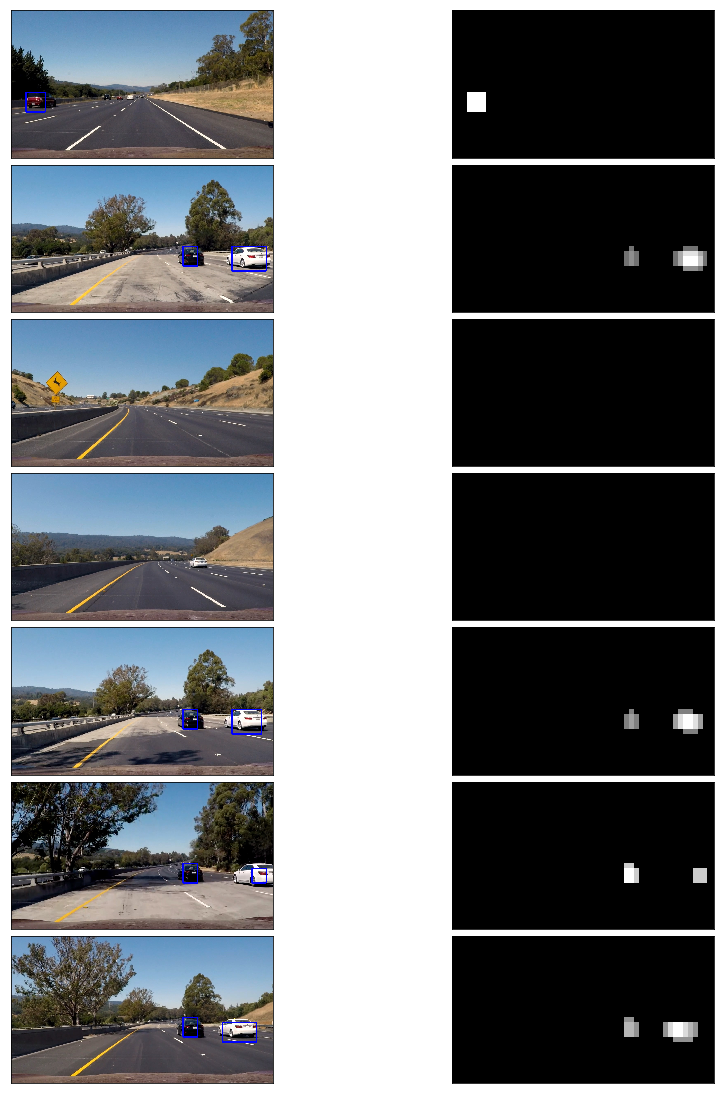

In [14]:
# Feature extraction parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' #Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
ystart, ystop = 400, 656
scale = 1.5
out_images, out_maps = [], []

for img in project_test_images:
    out_img, heat_map = pipeline_methods.find_cars(img, ystart, ystop,
              scale, svc, X_scaler, orient,
              pix_per_cell, cell_per_block,
              spatial_size, hist_bins)
    # Apply threshold to help remove false positives
    heat_map = pipeline_methods.apply_threshold(heat_map, 3)
    labels = pipeline_methods.label(heat_map)
    # Draw bounding boxes 
    draw_img = pipeline_methods.draw_labeled_bboxes(np.copy(img), labels)
    out_images.append(draw_img)
    out_images.append(heat_map)
utils.show_images(out_images, image_name='finding_cars', cols=2)

# Videos

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
def process_image(img):
    out_img, heat_map = pipeline_methods.find_cars(img, ystart, ystop,
              scale, svc, X_scaler, orient,
              pix_per_cell, cell_per_block,
              spatial_size, hist_bins)
     # Apply threshold to help remove false positives
    heat_map = pipeline_methods.apply_threshold(heat_map, 2)
    labels = pipeline_methods.label(heat_map)
    # Draw bounding boxes 
    draw_img = pipeline_methods.draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [39]:
imp.reload(pipeline_methods)

<module 'pipeline_methods' from 'C:\\Users\\modmo\\SelfDrivingCar\\projects\\vehicle_detection\\CarND-Vehicle-Detection\\pipeline_methods.py'>

In [35]:
# Read in the saved objpoints and imgpoints
dist_pickle = pickle.load( open( "calibration_values.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
# model_file = 'model_berkely_drivable_and_small_2.h5'
# k_model = kerasmodel.KerasModel(model_file=model_file,
#                              load=True)
road_object_finder = pipeline_methods.RoadObjectFinder(mtx, dist, svc, X_scaler)
test_output = 'test_videos_output/test_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(road_object_finder.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(test_output, audio=False)
#Close the reader properly 
clip1.reader.close()
clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video test_videos_output/test_video.mp4
[MoviePy] Writing video test_videos_output/test_video.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:30<00:00,  1.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/test_video.mp4 

Wall time: 30.9 s


In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))

In [37]:
# lane_line_finder  = adv_laneline_detection.LaneLineFinder(mtx, dist, k_model)
project_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(road_object_finder.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False)
#Close the reader properly 
clip1.reader.close()
clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [16:33<00:00,  1.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

Wall time: 16min 33s


In [38]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [43]:
# lane_line_finder  = adv_laneline_detection.LaneLineFinder(mtx, dist, k_model)
project_output = 'test_videos_output/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(road_object_finder.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False)
#Close the reader properly 
clip1.reader.close()
clip1.audio.reader.close_proc()

OSError: [WinError 6] The handle is invalid

In [42]:
clip1.reader.close()
clip1.audio.reader.close_proc()

In [38]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

## Videos SegNet

In [59]:
lane_line_finder = adv_laneline_detection.LaneLineFinder(mtx, dist, k_model)
test_output = 'test_videos_output/test_video_SEG.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(lane_line_finder.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(test_output, audio=False)
#Close the reader properly 
clip1.reader.close()
clip1.audio.reader.close_proc()

Succesfully loaded model_berkely_drivable_and_small_2.h5
[MoviePy] >>>> Building video test_videos_output/test_video_SEG.mp4
[MoviePy] Writing video test_videos_output/test_video_SEG.mp4



 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:03<00:00, 10.45it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/test_video_SEG.mp4 

Wall time: 4.07 s


In [60]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))

In [61]:
lane_line_finder  = adv_laneline_detection.LaneLineFinder(mtx, dist, k_model)
project_output = 'test_videos_output/project_video_SEG.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(lane_line_finder.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False)
#Close the reader properly 
clip1.reader.close()
clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video test_videos_output/project_video_SEG.mp4
[MoviePy] Writing video test_videos_output/project_video_SEG.mp4



 21%|████████████████▌                                                              | 264/1261 [00:25<01:36, 10.29it/s]


 40%|███████████████████████████████▌                                               | 504/1261 [00:49<01:14, 10.22it/s]


 61%|████████████████████████████████████████████████▍                              | 773/1261 [01:15<00:47, 10.25it/s]


 83%|████████████████████████████████████████████████████████████████▋             | 1045/1261 [01:41<00:20, 10.29it/s]


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:02<00:00, 10.29it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_SEG.mp4 

Wall time: 2min 2s


In [62]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))